In [1]:
import numpy as np
import os
import pickle
import time
import sys
import itertools
from tqdm.notebook import tqdm
import open3d as o3d
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from scipy.spatial.transform import Rotation as R

In [3]:
np.set_printoptions(precision=6)

### Dataset utils

In [4]:
class Kitti(Dataset):
    def __init__(self, scan_dir, pose_dir, transform, test_sequence=None, split='train'):
        self.scan_dir = scan_dir # lidar scans
        self.pose_dir = pose_dir # ground-truth poses
        self.split = split
        self.transform = transform
        self.projected = {} # dict to store transformed scans
        
        if self.split == 'train':
            self.sequence_idx = '07' # TODO: make train/val data include multiple sequences instead??
        elif self.split == 'validate':
            self.sequence_idx = '04'
        elif self.split == 'test':
            self.sequence_idx = test_sequence
            
        self.velo_files = self.load_velo_files(self.sequence_idx)
        self.poses = self.load_poses(self.sequence_idx)

    def __len__(self):
        return len(self.velo_files)
    
    def __repr__(self):
        return "Total frames: {}, total poses: {} in {} sequence {}".format(len(self.velo_files),
                                                                    len(self.poses), self.split, self.sequence_idx)
    
    def __getitem__(self, index: int):
        if index == 0:
            prev_index = 0
        else:
            prev_index = index - 1

        curr_scan, prev_scan = self.load_velo(index), self.load_velo(prev_index) # velo scans
        
        # if scans already projected, grab from memory; else transform scans and add to memory
        if index in self.projected.keys():
            curr_img = self.projected[index]
        else:
            curr_img = self.transform(curr_scan)
            self.projected[index] = curr_img
            
        if prev_index in self.projected.keys():
            prev_img = self.projected[prev_index]
        else:
            prev_img = self.transform(prev_scan)
            self.projected[prev_index] = prev_img
        
        # grab poses and compute relative pose
        curr_pose, prev_pose = self.poses[index], self.poses[prev_index]
        rel_pose = np.linalg.inv(prev_pose) @ curr_pose 
        return curr_img, prev_img, rel_pose
    
    def load_velo_files(self, seq_idx):
        sequence_dir = os.path.join(self.scan_dir, seq_idx, 'velodyne')
        sequence_files = sorted(os.listdir(sequence_dir))
        velo_files = [os.path.join(sequence_dir, frame) 
                              for frame in sequence_files]
        return velo_files
    
    def load_velo(self, item: int): 
        """Load velodyne [x,y,z,i] scan data from binary files."""
        filename = self.velo_files[item]
        scan = np.fromfile(filename, dtype=np.float32)
        scan = scan.reshape((-1,4)) 
        return scan
    
    def load_poses(self, sequence):
        pose_file = os.path.join(self.pose_dir, sequence + '.txt')
        poses = [] # store 4x4 pose matrices
        try:
            with open(pose_file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    pose_vector = np.fromstring(line, dtype=float, sep=' ')
                    pose_matrix = pose_vector.reshape(3, 4)
                    pose_matrix = np.vstack((pose_matrix, [0, 0, 0, 1]))
                    poses.append(pose_matrix)      
        except FileNotFoundError:
            print('Ground truth poses are not available for sequence ' +
                  sequence + '.')
        return poses  
    
    def visualise(self, index: int):
        img, _, _ = self.__getitem__(index)
        img = img.permute(1,2,0).numpy()
        img_intensity = img[:,:,4] * (255.0 / img[:,:,4].max()) # [xyz range intensity normals]
        img_range = img[:,:,3] * (255.0 / img[:,:,3].max())
        
        fig, axs = plt.subplots(2, figsize=(12,6), dpi=100)
        axs[0].imshow(img_intensity)
        axs[0].set_title("Intensity map")
        axs[1].imshow(img_range) # invert normalize TODO: invert or not??
        axs[1].set_title("Depth map")
        plt.show();

### Point cloud downsampler (experiment)

In [6]:
# sampling config
n_points = 4096 

In [7]:
class PointCloudSampler():
    def __init__(self, output_n: int):
        self.output_n = output_n
    
    def sample_index(self, xyz):
        """ Returns sample indices for pointcloud """
        N = xyz.shape[0]
        centroids = np.zeros(self.output_n)
        distance = np.ones(N) * 1e10
        farthest = np.random.randint(0, N)
        print("Sampling pointclouds ...")
        for i in tqdm(range(self.output_n)):
            # Update the i-th farthest point
            centroids[i] = farthest
            # Take the xyz coordinate of the farthest point
            centroid = xyz[farthest, :]
            # Calculate the Euclidean distance from all points in the point set to this farthest point
            dist = np.sum((xyz - centroid) ** 2, -1)
            # Update distances to record the minimum distance of each point in the sample from all existing sample points
            mask = dist < distance
            distance[mask] = dist[mask]
            # Find the farthest point from the updated distances matrix, and use it as the farthest point for the next iteration
            farthest = np.argmax(distance, -1)
        return centroids.astype(int)
    
    def __call__(self, pointcloud):
        assert pointcloud.shape[1] == 4 # XYZI
        xyz = pointcloud[:,:-1] # extract xyz
        centroids = self.sample_index(xyz)
        
        sampled_pointcloud = pointcloud[centroids, :]
        
        return sampled_pointcloud

### Lidar encoding (spherical projection + normal estimation)

In [8]:
# velodyne config
fov_up = 2 # deg
fov_down = -24.8
num_lasers = 64 # H
img_length = 1800 # W

In [39]:
class LidarEncoder():
    def __init__(self, fov_up, fov_down, num_lasers: int, img_length: int):
        self.num_lasers = num_lasers
        self.img_length = img_length
        
        self.fov_up_rad = (fov_up / 180) * np.pi
        self.fov_down_rad = (fov_down / 180) * np.pi
        self.fov_rad = abs(self.fov_up_rad) + abs(self.fov_down_rad)
    
    def get_u_v(self, point):
        assert point.shape[0] == 3 # XYZ

        x, y, z = point
        r = np.sqrt(x ** 2 + y ** 2 + z ** 2) # range
        yaw = np.arctan2(y, x)
        pitch = np.arcsin(z / r)

        # Get projections in image coords and normalizing
        v = 0.5 * (yaw / np.pi + 1.0)
        u = 1.0 - (pitch + abs(self.fov_down_rad)) / self.fov_rad
        # Scaling as per the lidar config given
        v *= self.img_length;
        u *= self.num_lasers;
        # round and limit for use as index
        v = np.floor(v);
        v = min(self.img_length - 1, v);
        v = max(0.0, v);
        pixel_v = int(v); # col

        u = np.floor(u);
        u = min(num_lasers - 1, u);
        u = max(0.0, u);
        pixel_u = int(u); # row

        return pixel_u, pixel_v, r
    
    def estimate_normals(self, pointcloud):
        pointcloud_xyz = pointcloud[:,:-1]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pointcloud_xyz)
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=4)) # PCA w/ knn
    
        # o3d.visualization.draw_geometries([pcd], point_show_normal=True)
        normals = np.asarray(pcd.normals)
        return normals
    
    def __call__(self, pointcloud):
        assert pointcloud.shape[1] == 4 # XYZI
        N = pointcloud.shape[0]
        projection = np.zeros((self.num_lasers, self.img_length, 8)) # feature_channels = 8
        normals = self.estimate_normals(pointcloud) # estimate normals
        
        # create image projection # TODO: make this faster !!!
        for i in range(N): 
            point = pointcloud[i,:-1] # grab XYZ
            intensity = pointcloud[i,-1]
            normal = normals[i, :] # xyz normals
            pixel_u, pixel_v, r = self.get_u_v(point)
            projection[pixel_u, pixel_v] = np.concatenate(([point[0], point[1], point[2], r, intensity], 
                                                            normal))
    
        # projection = projection[:, 4:1796, :] # crop resize to W=1792 as in paper
        return projection

In [40]:
# Transforms --> [Sampler(), LidarEncoder(), ToTensor()]
lidar_transform = transforms.Compose([LidarEncoder(fov_up, fov_down, num_lasers, img_length), 
                                      transforms.ToTensor()])

In [41]:
# path to KITTI dataset 
scan_dir = '../../KITTI/data/dataset/sequences'
pose_dir = '../../KITTI/data/dataset/poses'
train_data = Kitti(scan_dir, pose_dir, transform=lidar_transform)
val_data = Kitti(scan_dir, pose_dir, split='validate', transform=lidar_transform)

In [42]:
print(train_data)
print(val_data)

Total frames: 1101, total poses: 1101 in train sequence 07
Total frames: 271, total poses: 271 in validate sequence 04


In [43]:
train_dataloader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, drop_last=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=8, drop_last=True)

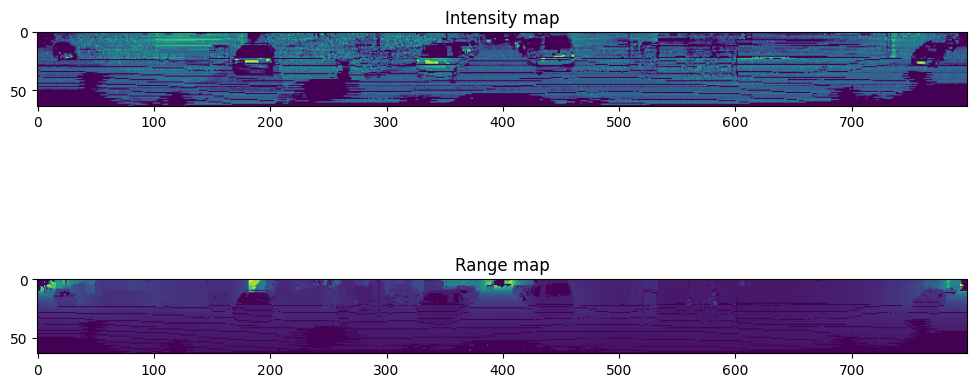

In [405]:
train_data.visualise(100)

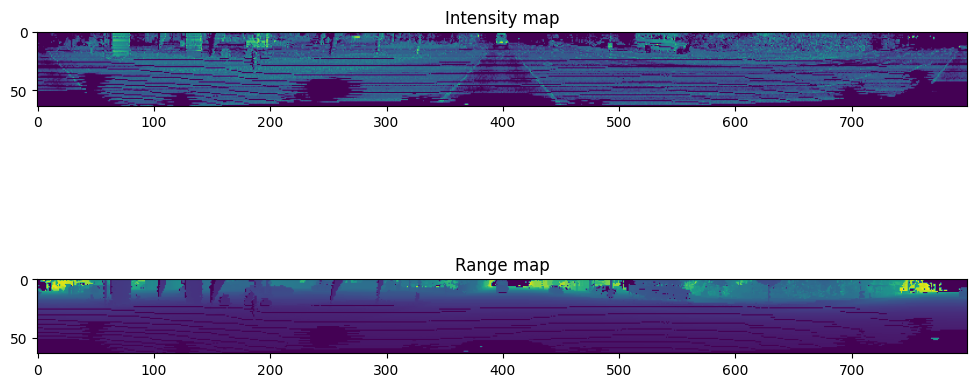

In [404]:
val_data.visualise(0)

In [46]:
curr_scan = train_data.load_velo(0)
curr_img = train_data.projected[0]
sampled_curr = PointCloudSampler(n_points)(curr)

In [25]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(sampled_curr[:,:-1])
o3d.visualization.draw_geometries([pcd])

### Normal estimation (method from paper)

In [47]:
encoder = LidarEncoder(fov_up, fov_down, num_lasers, img_length)

def weight(x1,x2):
    _, _, r1 = encoder.get_u_v(x1)
    _, _, r2 = encoder.get_u_v(x2)
    range_diff = abs(r1 - r2)
    return np.exp(-0.2*range_diff)

def get_neighbors(img, p):
    u,v, _ = encoder.get_u_v(p) # get pixel coords
    u_end = img.shape[0]-1
    v_end = img.shape[1]-1
    # print(u,v)
    
    # get k=4 nearest-neighbors (up-down-left-right)
    # TODO: change edge pixel cases to only 2-neighbors (better adjacent search overall)
    if u == u_end or v == v_end:  
        nn1 = img[max(u+1,0),v,:3]
        nn2 = img[u,max(v-1,0),:3]
        return np.array([nn1,nn2])
    else:
        nn1 = img[max(u-1,0),v,:3]
        nn2 = img[u,max(v-1,0),:3]
        nn3 = img[min(u+1,u_end),v,:3]
        nn4 = img[u,min(v+1,v_end),:3]
        return np.array([nn1, nn2, nn3, nn4])

def get_normal(img, p):
    neighbors = get_neighbors(img, p)
    k = neighbors.shape[0] # k-neighbors
    normal = 0
    for i,j in itertools.combinations(range(k),2):
        n_i = neighbors[i]
        n_j = neighbors[j]
        prod = np.cross(weight(n_i,p) * (n_i - p), 
            weight(n_j,p) * (n_j - p))
        normal += prod

    return (normal / np.linalg.norm(normal))

In [ ]:
N = curr_scan.shape[0]
normals = np.zeros((N, 3))
for i in tqdm(range(N)):
    normal = get_normal(curr_img.permute(1,2,0).numpy(), curr_scan[i,:-1])
    normals[i,:] = normal

In [52]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(curr_scan[:,:-1])
pcd.normals = o3d.utility.Vector3dVector(normals)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [50]:
normals.shape # using method in paper

(122626, 3)

In [51]:
# Open3D's method
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(curr_scan[:,:-1])
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=4)) # PCA w/ knn
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

### Network model

In [14]:
class FireConv(nn.Module):
    """ FireConv layer"""
    def __init__(self, inplanes: int, c1: int, c2: int, c3: int) -> None:
        super(FireConv, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.squeeze = nn.Conv2d(inplanes, c1, kernel_size=1)
        self.expand1x1 = nn.Conv2d(c1, c2, kernel_size=1)
        self.expand3x3 = nn.Conv2d(c1,c3, kernel_size=3, padding=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.squeeze(x))
        return torch.cat([
            self.relu(self.expand1x1(x)),
            self.relu(self.expand3x3(x))], 1)
        
class SELayer(nn.Module):
    """ Squeeze and Excitation layer from SEnet (channel attention) """
    def __init__(self, in_features: int, reduction=16) -> None:
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # 1x1 output size
        self.fc = nn.Sequential(
            nn.Linear(in_features, in_features // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_features // reduction, in_features, bias=False),
            nn.Sigmoid())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # BxC
        y = self.fc(y).view(b, c, 1, 1) # BxCx1x1
        x_scaled = x * y.expand_as(x) # BxCxHxW
        return x_scaled    

    
class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=128):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False), # conv1x1
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate)) # conv w/ rate dilations

        modules.append(ASPPPooling(in_channels, out_channels)) # global average pooling

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False), # conv1x1
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.25))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

    
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)

    
class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

In [15]:
class MaskEncoder(nn.Module):
    """ mask prediction network encoder """
    def __init__(self, c: int) -> None:
        super(MaskEncoder, self).__init__()

        self.conv1 = nn.Conv2d(c, 64, kernel_size=3, stride=(1,2), padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=(1,2), padding=1)
        self.fire1 = FireConv(64, 16, 64, 64)
        self.fire2 = FireConv(128, 16, 64, 64)
        self.se1 = SELayer(128, reduction=2)
        
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=(1,2), padding=1)
        self.fire3 = FireConv(128, 32, 128, 128)
        self.fire4 = FireConv(256, 32, 128, 128)
        self.se2 = SELayer(256, reduction=2)
        
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=(1,2), padding=1)
        self.fire5 = FireConv(256, 48, 192, 192)
        self.fire6 = FireConv(384, 48, 192, 192)
        self.fire7 = FireConv(384, 64, 256, 256)
        self.fire8 = FireConv(512, 64, 256, 256)
        self.se3 = SELayer(512, reduction=2)
        
        # Enlargement layer
        self.aspp = ASPP(512, [6, 9, 12])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_c1 = F.relu(self.conv1(x), inplace=True)
        x_p1 = self.pool1(x_c1)
        x_f1 = self.fire1(x_p1)
        x_f2 = self.fire2(x_f1)
        x_se1 = self.se1(x_f2)
        
        x_p2 = self.pool2(x_se1)
        x_f3 = self.fire3(x_p2)
        x_f4 = self.fire4(x_f3)
        x_se2 = self.se2(x_f4)
        
        x_p3 = self.pool3(x_se2)
        x_f5 = self.fire5(x_p3)
        x_f6 = self.fire6(x_f5)
        x_f7 = self.fire7(x_f6)
        x_f8 = self.fire8(x_f7)
        x_se3 = self.se3(x_f8)
        
        x_el = self.aspp(x_se3)
        return x_el

In [250]:
class OdomRegNet(nn.Module):
    """ Main odometry regression network - 2-stream net """
    def __init__(self, feature_channels=8):
        super(OdomRegNet, self).__init__()

        self.mask_encode = MaskEncoder(feature_channels) # [xyz range intensity normals]

        self.fire_1 = FireConv(256, 64, 256, 256)
        self.fire_2 = FireConv(512, 64, 256, 256)
        self.se_1 = SELayer(512, reduction=2)
        
        self.pool_1 = nn.MaxPool2d(kernel_size=3, stride=(2,2), padding=1)
        self.fire_3 = FireConv(512, 80, 384, 384)
        self.fire_4 = FireConv(768, 80, 384, 384)
        
        self.pool_2 = nn.MaxPool2d(kernel_size=3, stride=(2,2), padding=1)
        self.fc1 = nn.Linear(344064, 512)
        self.dropout = nn.Dropout2d(p=0.5)
        
        self.fc2 = nn.Linear(512, 3)
        self.fc3 = nn.Linear(512, 4) 
    
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        x_mask_out = torch.cat([self.mask_encode(x), self.mask_encode(y)], 1) # B, C',H, W
        x_f1 = self.fire_1(x_mask_out) 
        x_f2 = self.fire_2(x_f1)
        x_se = self.se_1(x_f2)
        
        x_p1 = self.pool_1(x_se)
        x_f3 = self.fire_3(x_p1)
        x_f4 = self.fire_4(x_f3)
        
        x_p2 = self.pool_2(x_f4)
        x_p2 = x_p2.view(x_p2.size(0), -1) # flatten
        x_fc1 = self.dropout(self.fc1(x_p2))
        
        x_out = self.fc2(x_fc1) # translation x
        q_out = self.fc3(x_fc1) # rotation quarternion q
        return x_out, q_out

### Loss function + eval metrics

In [247]:
class PoseLoss(nn.Module):
    """ Geometric loss function from PoseNet paper """
    def __init__(self, sx, sq, eps=1e-6):
        super(PoseLoss, self).__init__()
        self.sx = nn.Parameter(torch.Tensor([sx]))
        self.sq = nn.Parameter(torch.Tensor([sq]))
        self.eps = eps # numerical stability during backprop
        self.mse = nn.MSELoss() # TODO: try experimenting with L1-norm
        
    def forward(self, pred_x, pred_q, target_x, target_q):
        pred_q = F.normalize(pred_q, p=2, dim=1)
        loss_x = torch.sqrt(self.mse(target_x, pred_x) + self.eps) # L2-norm (RMSE)
        loss_q = torch.sqrt(self.mse(target_q, pred_q) + self.eps)
        
        loss = torch.exp(-self.sx)*loss_x + self.sx \
               + torch.exp(-self.sq)*loss_q + self.sq
        
        return loss, loss_x, loss_q

In [240]:
def get_x_q(pose: torch.Tensor):
    """ Get x, q vectors from pose matrix 
    Args:
        pose (Bx4x4 array): relative pose
    Returns:
        x (Bx3x1 array): translation 
        q (Bx4x1 array): quarternion
    """
    x = pose[:, :-1, -1]
    rot = pose[:, :-1, :-1] 
    r = R.from_matrix(rot.detach().numpy())
    q = torch.from_numpy(r.as_quat())
    
    return x.float(), q.float()

def get_pose(x, q):
    """ Get 4x4 pose from x and q numpy vectors
    Args:
        x (3x1 array): translation 
        q (4x1 array): quarternion
    Returns:
        pose (4x4 array): transformation pose
    """
    pose = np.identity(4)
    r = R.from_quat(q)
    rot = r.as_matrix()
    pose[:-1, :-1] = rot
    pose[:-1, -1] = x
    
    return pose

def rotation_error(pose_error):
    """ Compute rotation error
    Args:
        pose_error (4x4 array): relative pose error
    Returns:
        rot_error (float): rotation error
    """
    a = pose_error[0, 0]
    b = pose_error[1, 1]
    c = pose_error[2, 2]
    d = 0.5*(a+b+c-1.0)
    rot_error = np.arccos(max(min(d, 1.0), -1.0))
    return rot_error

def translation_error(pose_error):
    """ Compute translation error
    Args:
        pose_error (4x4 array): relative pose error
    Returns:
        trans_error (float): translation error
    """
    dx = pose_error[0, 3]
    dy = pose_error[1, 3]
    dz = pose_error[2, 3]
    trans_error = np.sqrt(dx**2+dy**2+dz**2)
    return trans_error

### Training 

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(1)
print(device)

cpu


In [268]:
model = OdomRegNet().to(device)
criterion = PoseLoss(sx=0.0, sq=-2.5).to(device)
optimizer = torch.optim.Adam([{'params': model.parameters()},
                              {'params': [criterion.sx, criterion.sq]}],
                             lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # TODO: maybe try ReduceOnPlateau()?
writer = SummaryWriter(log_dir='summary_LO_net')

In [252]:
print("Total model parameters: {}".format(sum([np.prod(p.shape) for p in model.parameters()])))

Total model parameters: 180576935


In [53]:
def train(model, train_dataloader, val_dataloader=None, epochs=30, checkpoint_dir=None):
    # Pre-define variables to load/save best model
    best_train_loss = 10000
    if checkpoint_dir and os.path.isfile(checkpoint_dir):
        print("=> Loading checkpoint from '{}'".format(checkpoint_dir))
        
        checkpoint = torch.load(checkpoint_dir, map_location=device)
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr'])
        
        print("=> Loaded checkpoint. Resuming from epoch {}".format(start_epoch+1))
        print("=> Best val loss = {:.6f}".format(best_val_loss))
    
    else:
        print("=> No checkpoint found.".format(checkpoint_dir))
        
        start_epoch = 0
        best_val_loss = 10000
        
    print('#' * 40)
    print("Starting training ... ")
    print('#' * 40)
    
    for epoch in range(start_epoch, epochs):
        model.train()
        start_time = time.time() # epoch start time
        error_train = []
        error_val = []
        
        for i, inputs in enumerate(train_dataloader, start=1):
            step_val = epoch * len(val_dataloader) + i
            print('[Epoch: %d / %d, Batch: %4d / %4d]' %(epoch + 1, epochs, i, len(train_dataloader)))
            curr_img, prev_img, pose_gt = inputs
            curr_img, prev_img, pose_gt = \
                        curr_img.to(device).float(), prev_img.to(device).float(), pose_gt.to(device).float()
            
            x_out, q_out = model(curr_img, prev_img) # predicted pose
            x_true, q_true = get_x_q(pose_gt) # true pose
            
            loss, loss_x, loss_q = criterion(x_out, q_out, x_true, q_true)
            print('sx = {:.6f}, sq = {:.6f}'.format(criterion.sx.item(), criterion.sq.item()))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            error_train.append(loss.item())
            print('Train loss: total loss {:.6f} / x-loss {:.6f} / q-loss {:.6f}'.format(loss.item(), loss_x.item(), loss_q.item()))
            print()
            
            writer.add_scalars("train_loss", {'total':loss.item(),
                                              'x':loss_x.item(),
                                              'q': loss_q.item()}, step_val)
            writer.add_scalars("optim", {'sx': criterion.sx.item(),
                                         'sq': criterion.sq.item()}, step_val)
            
            if i == 30: # train on only 30 batches
                break

        lr_scheduler.step()
        print("LR: {}".format(lr_scheduler.get_last_lr()[0]))
        writer.add_scalar("LR", lr_scheduler.get_last_lr()[0], epoch)
        
        if val_dataloader:
            print('#' * 40)
            print("Validating ... ")
            print('#' * 40)
            model.eval()
            
            with torch.no_grad():
                for i, inputs in enumerate(val_dataloader, start=1):
                    step_val = epoch * len(val_dataloader) + i
                    print('[Epoch: %d / %d, Batch: %4d / %4d]' %(epoch + 1, epochs, i, len(val_dataloader)))
                    curr_img, prev_img, pose_gt = inputs
                    curr_img, prev_img, pose_gt = \
                            curr_img.to(device).float(), prev_img.to(device).float(), pose_gt.to(device).float()
                    
                    x_out, q_out = model(curr_img, prev_img)
                    x_true, q_true = get_x_q(pose_gt)
                    
                    loss, loss_x, loss_q = criterion(x_out, q_out, x_true, q_true)
                    
                    error_val.append(loss.item())
                    print('Val loss: total loss {:.6f} / x-loss {:.6f} / q-loss {:.6f}'.format(loss.item(), loss_x.item(), loss_q.item()))
                    print()
                    
                    writer.add_scalars("val_loss", {'total':loss.item(),
                                              'x':loss_x.item(),
                                              'q': loss_q.item()}, step_val)
                    
        error_train_loss = np.mean(error_train) # avg. of accumulated losses per epoch
        error_val_loss = np.mean(error_val)
        
        print('[Epoch: {} ==> Train error {:.6f} / Validation error {:.6f}]'.format(epoch + 1, 
                                                                                    error_train_loss, error_val_loss))
        
        writer.add_scalars('loss/trainval', {'train':error_train_loss,
                                                     'val':error_val_loss}, epoch)
        
        if error_train_loss < best_train_loss:
            best_train_loss = error_train_loss
        if error_val_loss < best_val_loss:
            best_val_loss = error_val_loss
            print()
            print("Saving model to new checkpoint ...")
            print('=' * 40)
            print()
            state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_val_loss': best_val_loss,
                'optimizer': optimizer.state_dict(),
                'lr': lr_scheduler.state_dict()
            }
            torch.save(state, "best_epoch_model.pth")
            
        time_elapsed = time.time() - start_time
        print('Epoch {} completed in {:.0f}m {:.0f}s'.format(epoch + 1, time_elapsed // 60, time_elapsed % 60))
        print('+' * 40)
        print()
        
    print('#' * 40)
    print('#' * 40)
    print("Training completed :)")

In [ ]:
model_dir = 'best_epoch_model.pth'
train(model, train_dataloader, val_dataloader, checkpoint_dir=model_dir)

In [254]:
# x = torch.rand((1, 8, 64, 1792)).to(device)
# y = torch.rand((1, 8, 64, 1792)).to(device)
# writer.add_graph(model, (x,y))

In [54]:
%load_ext tensorboard

In [55]:
%tensorboard --logdir 'summary_LO_net'

### Testing

In [415]:
def test(model, dataloader, test_model_path: str):
    model.eval()
    if os.path.isfile(test_model_path):
        print('=> Loading pretrained model at {}'.format(test_model_path))
        test_checkpoint = torch.load(test_model_path, map_location=device)
        model.load_state_dict(test_checkpoint['state_dict'])
        print("=> Loaded model")
        print("=" * 40)
    else:
        print("=> No model found at {}".format(test_model_path))
        return 
    
    estim_poses = []
    gt_poses = []
    trans_errors = []
    rot_errors = []
    
    for i, inputs in enumerate(dataloader, 1):
        print('[Batch: %4d / %4d]' %(i, len(dataloader)))
        curr_img, prev_img, pose_gt = inputs
        curr_img, prev_img, pose_gt = \
                curr_img.to(device).float(), prev_img.to(device).float(), pose_gt.to(device).float()

        x_out, q_out = model(curr_img, prev_img)
        x_out = x_out.squeeze(0).detach().numpy()
        q_out = F.normalize(q_out, p=2, dim=1).squeeze(0).detach().numpy()
        pose_out = get_pose(x_out, q_out)
        
        x_true, q_true = get_x_q(pose_gt)
        x_true = x_true.squeeze(0).numpy()
        q_true = q_true.squeeze(0).numpy()
        pose_true = pose_gt.squeeze(0).detach().numpy()
        
        print('x out: {}, q out: {}'.format(x_out, q_out))
        print('x true: {}, q true: {}'.format(x_true, q_true))
        
        pose_error = np.linalg.inv(pose_true) @ pose_out # relative pose error
        trans_error = translation_error(pose_error) 
        rot_error = rotation_error(pose_error) 
        
        estim_poses.append(pose_out)
        gt_poses.append(pose_true)
        
        trans_errors.append(trans_error)
        rot_errors.append(rot_error)
        
        print("Relative Pose Errors: translation: {:.6f} / rotation {:.6f}".format(trans_error, rot_error))
        print()
    
    print()
    print('+' * 40)
    print("Testing complete !!")
    print("Overall RMSE pose errors: translation {:.6f} / rotation {:.6f}".format(np.sqrt(np.mean(np.asarray(trans_errors) ** 2)),
                                                                                  np.sqrt(np.mean(np.asarray(rot_errors) ** 2))))
    print('+' * 40)
        
    return estim_poses, gt_poses

In [56]:
test_data = Kitti(scan_dir, pose_dir, split='test', test_sequence='06'
                  , transform=lidar_transform)
test_dataloader = DataLoader(dataset=test_data, batch_size=1)
print(test_data)

Total frames: 1101, total poses: 1101 in test sequence 06


In [ ]:
result_06, gt_06 = test(model, test_dataloader, test_model_path='best_epoch_model.pth')

In [426]:
# Save pose array as txt
f_result = 'result_06.npy'
np.save(f_result, result_06)

In [453]:
rel = np.load('result_06.npy')
rel_gt = gt_06

In [446]:
# Reconstruct global poses from odometry
assert len(rel) == len(rel_gt)
pred = np.zeros((len(rel), 4, 4))
gt = np.zeros((len(rel), 4, 4))
for i in range(len(rel)):
    if i == 0:
        pred[i] = pred_prev = np.identity(4)
        gt[i] = gt_prev = rel_gt[i]
        continue
        
    pred[i] = pred_prev @ rel[i]
    gt[i] = gt_prev @ rel_gt[i]
    pred_prev = pred[i]
    gt_prev = gt[i]

In [382]:
%matplotlib inline

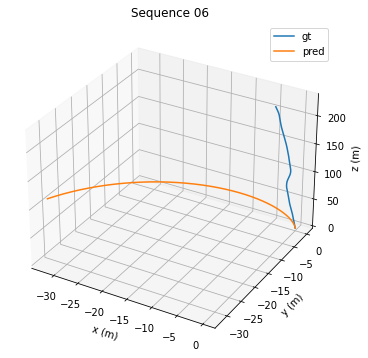

In [447]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')
# fig, ax = plt.subplots(figsize=(12,6))
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2], label='gt')
ax.plot(pred[:,:, 3][:, 0], pred[:, :, 3][:, 1], pred[:, :, 3][:, 2], label='pred')
ax.title.set_text("Sequence 06")

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.legend()

# ax.set_xlim([-100,100])
# ax.view_init(elev=-80, azim=270)

(-100.0, 100.0)

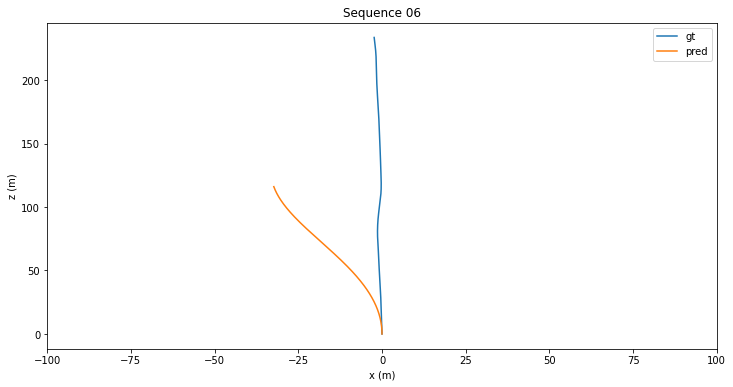

In [454]:
# fig = plt.figure(figsize=(12,6))
# ax = plt.axes(projection='3d')
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 2], label='gt')
ax.plot(pred[:,:, 3][:, 0], pred[:, :, 3][:, 2], label='pred')
ax.title.set_text("Sequence 06")

ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
# ax.set_zlabel('z (m)')
ax.legend()
ax.set_xlim([-100,100])
# ax.view_init(elev=-80, azim=270)